<a href="https://colab.research.google.com/github/AayushKucheria/ML-Bootcamp/blob/main/Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformer







This is an ever-updating notebook where I



*   Build a transformer from scratch (mostly using Annotated Transformer)
*   Try it out on different tasks
* Run different experiments and play around with it
* Modify certain parts and explore the changes that take place



# Maintainence Stuff (skip)

In [ ]:
!pip install -q torchdata torchtext spacy altair GPUtil
!python -m spacy download de_core_news_sm
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 4.4 MB 8.6 MB/s 
     |████████████████████████████████| 140 kB 92.6 MB/s 
     |████████████████████████████████| 127 kB 83.0 MB/s 
2022-08-23 08:04:46.177596: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 14.6 MB 8.0 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
2022-08-23 08:04:55.958844: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 8.2 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_

In [ ]:
import os
from os.path import exists
import math
import copy
import time

import torch
import torch.nn as nn
from torch.nn.functional import log_softmax, pad
from torch.optim.lr_scheduler import LambdaLR
import pandas as pd
import altair as alt

from torchtext.data.functional import to_map_style_dataset
from torch.utils.data import DataLoader
from torchtext.vocab import build_vocab_from_iterator
import torchtext.datasets as datasets
import spacy


import GPUtil
import warnings
from torch.utils.data.distributed import DistributedSampler
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP

warnings.filterwarnings("ignore")
RUN_EXAMPLES = True

In [ ]:
# Convenience helper functions

# TODO: don't understand the code here. Return function?

def is_interactive_notebook():
    return __name__ == "__main__"

def show_example(fn, args=[]):
    if __name__ == "__main__" and RUN_EXAMPLES:
        return fn(*args)

def execute_example(fn, args=[]):
    if __name__ == "__main__" and RUN_EXAMPLES:
        fn(*args)

# TODO: Oo smart.
class DummyOptimizer(torch.optim.Optimizer):
    def __init__(self):
        self.param_groups = [{"lr": 0}]
        None

    def step(self):
        None
    
    def zero_grad(self, set_to_none=False):
        None
    
class DummyScheduler:
    def step(self):
        None

# Model Architecture

In [ ]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many
    other models
    """

    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
    
    def forward(self, src, tgt, src_mask, tgt_mask):
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, contextVector, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), contextVector, src_mask, tgt_mask)    

In [ ]:
class Generator(nn.Module):
    """
    Define standard linear + softmax generation step
    ---
    Given an embedding, generates an output sequence
    one element at a time
    """

    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()

        self.proj = nn.Linear(d_model, vocab) # Embedding -> Vocabulary
    
    def forward(self, x):
        return log_softmax(self.proj(x), dim=-1) # Return probabilities

## Encoder and Decoder Stacks

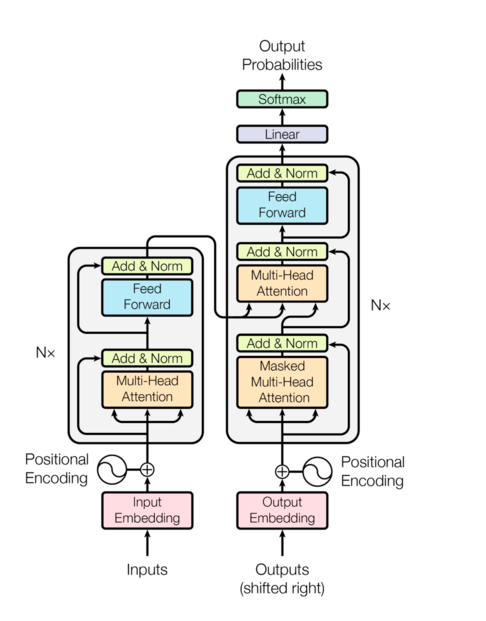

In [ ]:
def clones(module, N):
    "Produce N identical modules"
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

### 1.1.1. Encoder

In [ ]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"

    def __init__(self, block, N): # block
        super(Encoder, self).__init__()

        self.blocks = clones(block, N)
        self.norm = LayerNorm(block.size)
    
    def forward(self, x, padding_mask):
        """
        padding_mask: Used to hide the (if any) padding values in the input sequence
        """
        for block in self.blocks:
            out = block(x, padding_mask)
        
        return self.norm(x)

Each block in an Encoder consists of two sublayers. There is a residual connection around each of the two sub-layers, which is followed by layer normalization (check viz)

LayerNorm explanation: https://arxiv.org/abs/1607.06450 (implemented by default in pytorch: nn.LayerNorm)

Equation: $\frac{x - E(x)}{\sigma + \epsilon}*a + b$

In [ ]:
class LayerNorm(nn.Module):
    "Constructing a layernorm module"

    # TODO: What's the difference between LayerNorm, BatchNorm, and InstanceNorm?
    # Check paper and pytorch page
    def __init__(self, features, eps=1e-6):

        super(LayerNorm, self).__init__()
        # Learnable variable 1
        self.a = nn.Parameter(torch.ones(features)) # initialized as 1 since involved in multiply
        # Learnable variable 2
        self.b = nn.Parameter(torch.zeros(features)) # initialized as 0 since involved in sum
        self.eps = eps

    def forward(self, x):
        x = x.float()

        mean = x.mean(-1, keepdim=True) # Ah, keepdim is an interesting hack
        std = x.std(-1, keepdim=True)

        res = (x-mean)/(std + self.eps)
        return  self.a * res + self.b




The output of each sub-layer is **LayerNorm(x + SubLayer(x))**

Where SubLayer(x) is the function implemented by the specific sublayer.

To facilitate the residual connections, all sub-layers in the model, as well as the embedding layers, produce outputs of dimension $d_{model} = 512$ 

In [ ]:
class SublayerConnection(nn.Module):

    """
    A residual connection followed by a layer norm.
    """

    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()

        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):

        out = self.norm(x) # Note that we're applying this first as opposed to last, for code simplicity. Why doesn't it fuck up the code tho? Coz it's layerNorm.
        out = sublayer(out)
        out = self.dropout(out)

        return x + out

Each block has two sub-layers. The first is a multi-head self-attention mechanism, and the second is a simple, position-wise fully connected feed-forward network.



In [ ]:

class EncoderBlock(nn.Module): # Every module in pytorch is a subclass of nn.Module
    "Encoder is made up of self-attn and feed forward"

    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderBlock, self).__init__() # Delegates function calls to parent. Useful for inheritance 

        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size # Most likely d_{model} = 512
    
    def forward(self, x, mask):
        
        # self_attn is the actual attention mechanism, while attn_layer is the block
        # where self_attn takes place (along with norm and other stuff)
        attn_layer = self.sublayer[0]
        ff_layer = self.sublayer[1]

        x = attn_layer(x, lambda x: self.self_attn(x, x, x, mask)) # K, Q, V, mask
        x = ff_layer(x, self.feed_forward)

### 1.1.2. Decoder

In [ ]:
class Decoder(nn.Module):
    "Core decoder is a stack of N layers"

    def __init__(self, block, N):
        super(Decoder, self).__init__()

        self.blocks = clones(block, N)
        self.norm = LayerNorm(block.size)

    def forward(self, x, context_vector, src_mask, tgt_mask):
        """
        src_mask: Hide padding in sequence
        tgt_mask: Hide future characters in sequence
        """
        
        for block in self.blocks:
            x = block(x, context_vector, src_mask, tgt_mask)
        return self.norm(x)            

In addition to the two sub-layers in each encoder layer, the decoder inserts a third sub-layer, which performs multi-head attention over the output of the encoder stack. Similar to the encoder, we employ residual connections around each of the sub-layers, followed by layer normalization.



In [ ]:
class DecoderBlock(nn.Module):
    "Decoder is made of self-attn, src_attn, and feed forward"

    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderBlock, self).__init__()
        
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        # God I love this coding style - abstracting away everything.
        self.sublayer = clones(SublayerConnection(size, dropout), 3)

    def forward(self, x, context_vector, src_mask, tgt_mask):

        c = context_vector # TODO What's this?
        attn_layer1 = self.sublayer[0]
        attn_layer2 = self.sublayer[1]
        ff_layer = self.sublayer[2]

        x = attn_layer1(x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = attn_layer2(x, lambda x: self.src_attn(x, c, c, src_mask)) # Hmm different variables self_attn and src_attn - what's the differnce?
        x = ff_layer(x, self.feed_forward)

        return x

We also modify the self-attention sub-layer in the decoder stack to prevent positions from attending to subsequent positions. This masking, combined with fact that the output embeddings are offset by one position, ensures that the predictions for position i can only depend on the known outputs at positions < i.

In [ ]:
def subsequent_mask(size):
    "Mask out subsequent positions"
    # TODO Yo what's this code doing line-by-line?
    attn_shape = (1, size, size)
    subsequent_mask = torch.triu(torch.ones(attn_shape), diagonal=1).type(torch.uint8)
    
    return subsequent_mask == 0


In [ ]:
def example_mask():
    LS_data = pd.concat(
        [
            pd.DataFrame(
                {
                    "Subsequent Mask": subsequent_mask(20)[0][x, y].flatten(),
                    "Window": y,
                    "Masking": x,
                }
            )
            for y in range(20)
            for x in range(20)
        ]
    )

    return (
        alt.Chart(LS_data)
        .mark_rect()
        .properties(height=250, width=250)
        .encode(
            alt.X("Window:O"),
            alt.Y("Masking:O"),
            alt.Color("Subsequent Mask:Q", scale=alt.Scale(scheme="viridis")),
        )
        .interactive()
    )


show_example(example_mask)

alt.Chart(...)

## Attention

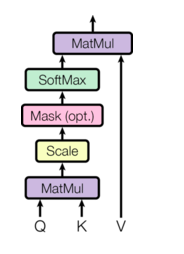

$Attention(Q, K, V) = softmax(\frac{QK^T}{\sqrt{d_k}})V$

In [ ]:
def attention(query, key, value, mask=None, dropout=None):

    "Computing Scaled Dot Product Attention"
    d_k = query.size(-1)
    # TODO How is the key transpose working here?
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)

    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)

    weights = scores.softmax(dim=-1)

    if dropout is not None:
        weights = dropout(weights)
    
    w_sum = torch.matmul(weights, value)
    
    return w_sum, weights

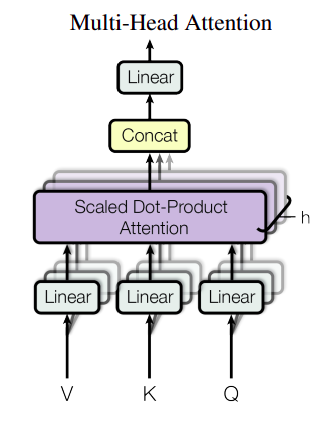

In [ ]:
class MultiHeadedAttention(nn.Module):

    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads"

        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0 # Aha this seems important

        # We assume d_v == d_k
        self.d_k = d_model // h # Floor division - rounds the result down 
        self.h = h

        # Each head only needs 3 linears (one each for Q, K, V)
        # The fourth one is used in the ending
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
    
    def forward(self, query, key, value, mask=None):

        # TODO: Understand/map all these shape transformations

        if mask is not None:
            # Same mask is applied to all heads
            mask = mask.unsqueeze(1)
        
        nbatches = query.size(0)


        # Step 1. Linear Projection
        # Push Q, K, V through a linear layer and reshape them
        query, key, value = [
            lin(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
            for lin, x in zip(self.linears, (query, key, value))
        ]

        # Step 2. Apply attention to the linear projections
        x, self.attn = attention(
            query, key, value, mask=mask, dropout=self.dropout
        )

        # Step 3. "Concat" and apply final linear layer
        x = (
            x.transpose(1, 2)
            .contiguous()
            .view(nbatches, -1, self.h * self.d_k)
        )
        x = self.linears[-1](x)

        del query
        del key
        del value
        return x

## Position-wise Feed-Forward Networks

In addition to attention sub-layers, each of the layers in our encoder and decoder contains a fully connected feed-forward network, which is applied to each position separately and identically. This consists of two linear transformations with a ReLU activation in between.



In [ ]:
class PositionWiseFeedForward(nn.Module):

    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionWiseFeedForward, self).__init__()

        self.layer1 = nn.Linear(d_model, d_ff)
        self.layer2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):

        x = self.layer1(x)
        x = self.dropout(x.relu())
        x = self.layer2(x)
        return x

## Embeddings and Softmax

We share the same weights b/w the two embedding layers and the pre-softmax linear transformation. Like same weights in all 4 of them together.

Though we multiply the weights by $\sqrt{d_{model}}$ in the embedding layer

In [ ]:
class Embeddings(nn.Module):

    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        # LUT = Look-Up Table (?) of embeddings
        self.lut = nn.Embedding(vocab, d_model) 
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

## Positional Encoding

In [ ]:
class PositionalEncoding(nn.Module):

    # I haven't spent time understanding this code yet.

    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()

        self.dropout = nn.Dropout(p=dropout)

        # Compute positional encodings once in log space
        # Why: Probably efficiency reasons?
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1)].requires_grad_(False)
        return self.dropout(x)

Below the positional encoding will add in a sine wave based on position. The frequency and offset of the wave is different for each dimension.



In [ ]:
def example_positional():
    pe = PositionalEncoding(20, 0)
    y = pe.forward(torch.zeros(1, 100, 20))

    data = pd.concat(
        [
            pd.DataFrame(
                {
                    "embedding": y[0, :, dim],
                    "dimension": dim,
                    "position": list(range(100)),
                }
            )
            for dim in [4, 5, 6, 7]
        ]
    )

    return (
        alt.Chart(data)
        .mark_line()
        .properties(width=800)
        .encode(x="position", y="embedding", color="dimension:N")
        .interactive()
    )


show_example(example_positional)

alt.Chart(...)

## Full Model

Defining a function from hyperparameters to a full model

In [ ]:
def make_model(
    src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1):
    """
    Constructing a model from hyperparameters
    N: ?
    d_model: Model Dimensions
    d_ff: ?
    h: Attention Heads
    """

    c = copy.deepcopy # Okay. Ig we're gonna use this a lot
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionWiseFeedForward(d_model, d_ff, dropout) # Why positionwise?
    position = PositionalEncoding(d_model, dropout)

    model = EncoderDecoder( # I quite like this format

        Encoder(EncoderBlock(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderBlock(d_model, c(attn), c(attn), c(ff), dropout), N),
        # Initial embedding layer of encoder
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        # Initial embedding layer of decoder
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        # Last: Linear and softmax?
        Generator(d_model, tgt_vocab)
    )


    # What is this doing? TODO
    # This was important from their code.
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

# Inference

Here we make a forward step to generate a prediction of the model. Note that we're doing this before training.

In [ ]:
def inference_test():

    test_model = make_model(11, 11, 2)
    test_model.eval()

    src = torch.LongTensor([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]])
    src_mask = torch.ones(1, 1, 10)

    context_vector = test_model.encoder(src, src_mask)
    ys = torch.zeros(1, 1).type_as(src) # TODO What's this?

    for i in range(9):
        # Get output embeddings
        out = test_model.decode(context_vector, src_mask, ys, subsequent_mask(ys.size(1)).type_as(src.data))
        # Use them to generate word probabilities
        probs = test_model.generator(out[:, -1])
        # Pick highest prob word
        _, next_word = torch.max(probs, dim=1)
        next_word = next_word.data[0]
        ys = torch.cat(
            [ys, torch.empty(1, 1).type_as(src.data).fill_(next_word)], dim=1
        )

    print("Example untrained model prediction: ", ys)

def run_tests():
    for _ in range(10):
        inference_test()
    

show_example(run_tests)

torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
tensor([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]])

tensor([[ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]])
torch.Size([512]) torch.Size([1, 10])


RuntimeError: ignored

# Training
Defining some of the tools needed to train a standard encoder decoder model.


First we define a batch object that holds the src and target sentences for training, as well as constructing the masks.

## Batches and Masking

In [ ]:
class Batch:
    """ Object for holding a batch of data with mask during training."""

    def __init__(self, src, tgt=None, pad=2): # 2 = <blank> TODO What does this mean?
    
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)

        if tgt is not None:
            self.tgt = tgt[:, :-1]
            self.tgt_y = tgt[:, 1:]
            self.tgt_mask = self.make_std_mask(self.tgt, pad)
            self.ntokens = (self.tgt_y != pad).data.sum()
    
    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words"

        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data)
        return tgt_mask

Next we create a generic training and scoring function to keep track of loss. We pass in a generic loss compute function that also handles parameter updates.



In [ ]:
class TrainState:
    """Track number of steps, examples, and tokens processed"""

    step: int = 0  # Steps in the current epoch
    accum_step: int = 0  # Number of gradient accumulation steps
    samples: int = 0  # total # of examples used
    tokens: int = 0  # total # of tokens processed

In [ ]:
def run_epoch(data_iter, model, loss_compute, optim, scheduler, mode="train", accum_iter=1, train_state=TrainState()):
    "Train a single epoch"

    start = time.time()
    n_accum = 0
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):        

        out = model.forward(batch.src, batch.tgt, batch.src_mask, batch.tgt_mask)

        # What is loss_node?
        loss, loss_node = loss_compute(out, batch.tgt_y, batch.ntokens)
        # loss_node = loss_node / accum_iter # WHY?

        if mode == "train" or mode == "train+log":

            loss_node.backward() # Oh, not loss.backward()? Okay. New question - what's loss?

            # Logging
            train_state.step += 1
            train_state.samples += batch.src.shape[0]
            train_state.tokens += batch.ntokens

            # Optim step
            # Default value  of accum_iter is 1. So update every step.
            # When would you not wanna do that?
            if i % accum_iter == 0:
                optim.step()
                optim.zero_grad(set_to_none=True) # I think the param exists for efficiency reasons?
                n_accum += 1
                train_state.accum_step += 1
            
            # TODO: what does this do?
            scheduler.step()

        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens

        if i % 40 == 1 and (mode == "train" or mode == "train+log"):
            lr = optim.param_groups[0]["lr"]
            elapsed = time.time() - start
            print(
                (
                    "Epoch Step: %6d | Accumulation Step: %3d | Loss: %6.2f "
                    + "| Tokens / Sec: %7.1f | Learning Rate: %6.1e"
                )
                % (i, n_accum, loss / batch.ntokens, tokens / elapsed, lr)
            )
            start = time.time()
            tokens = 0

        del loss
        del loss_node
    return total_loss / total_tokens, train_state




## Optimizer

We used the Adam optimizer (cite) with $\beta_1=0.9, \beta_2=0.98$ and $\epsilon=10^{-9}$.

## Learning Rate


We varied the learning rate over the course of training, according to the formula: $lrate = d_{model}^{-0.5} \cdot min(step\_num^{-0.5}, step\_num \cdot warmup\_steps^{-1.5})$

This corresponds to increasing the learning rate linearly for the first $warmup\_steps$ training steps, and decreasing it thereafter proportionally to the inverse square root of the step number.

We used $warmup\_steps = 4000$.

In [ ]:
def rate(step, model_size, factor, warmup):
    """
    We need to default the step to 1 for LambdaLR
    function to avoid zero raising to negative power
    """
    if step == 0:
        step = 1
    return factor * (
        model_size ** (-0.5) * min(step ** (-0.5), step * warmup ** (-1.5))
    )

In [ ]:
def simple_model():
    
    V = 11 # What's V? TODO
    # TODO use a predefined loss function? WHy not?
    # criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
    criterion = nn.CrossEntropyLoss()
    # I like this
    model = make_model(V, V, N=2)

    optim = torch.optim.Adam(model.parameters(), lr=0.5, betas=(0.9, 0.98), eps=1e-9)

    # What's this doing? TODO
    lr_scheduler = LambdaLR(
        optimizer = optim,
        lr_lambda = lambda step: rate(
            step, model_size=model.src_embed[0].d_model, factor=1.0, warmup=400
        ),
    )

    batch_size = 80
    for epoch in range(20):

        model.train() # Setting training mode on

        run_epoch(
            data_gen(V, batch_size, 20),
            model,
            SimpleLossCompute(model.generator, criterion),
            optim,
            lr_scheduler,
            mode="train"
        )

        model.eval()

        # What's this for?
        run_epoch(
            data_gen(V, batch_size, 5),
            model,
            SimpleLossCompute(model.generator, criterion),
            DummyOptimizer(),
            DummyScheduler(),
            mode="eval"
        )[0]

        model.eval() # Why again?
        src = torch.LongTensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])
        max_len = src.shape[1]
        src_mask = torch.ones(1, 1, max_len)
        print(greedy_decode(model, src, src_mask, max_len=max_len, start_symbol=0))

simple_model()


Epoch Step:      1 | Accumulation Step:   2 | Loss:   0.00 | Tokens / Sec:   353.1 | Learning Rate: 5.5e-06


KeyboardInterrupt: ignored

Inference

Here we make a forward step to generate a prediction of the model. We try to use our transformer to memorize the input. As you will see the output is randomly generated due to the fact that the model is not trained yet. In the next tutorial we will build the training function and try to train our model to memorize the numbers from 1 to 10.



In [ ]:
def inference_test():
    

In [ ]:
from torch.optim.lr_scheduler import LambdaLR


In [ ]:
def rate(step, model_size, factor, warmup):

    """
    We have to default the step to 1 for LambdaLR function
    to avoid zero raising to negative power.
    TODO: Bruh what?
    """
    if step == 0:
        step = 1
    return factor * (
        model_size ** (-0.5) * min(step ** (-0.5), step * warmup ** (-1.5))
    )

## Regularization

### Label Smoothing

Label smoothing actually starts to penalize the model if it gets very confident about a given choice.



During training, we employed label smoothing of value $\epsilon_{ls} = 0.1$. 

In [ ]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing"

    # TODO It's super interesting that we're using the init/forward framework
    # for implementing quite a few things here, aside from nns themselves.
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()

        self.criterion = nn.KLDivLoss(reduction="sum")
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
    
    def forward(self, x, target):
        assert x.size(1) == self.size

        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, true_dist.clone().detach())

# A Demo Example

Trying out the model on a super simple task

We can begin by trying out a simple copy-task. Given a random set of input symbols from a small vocabulary, the goal is to generate back those same symbols.



## Synthetic Data

In [ ]:
def data_gen(V, batch_size, nbatches):
    "Generate random data for a src-tgt copy task"

    for i in range(nbatches):
        data = torch.randint(1, V, size=(batch_size, 10))
        data[:, 0] = 1
        src = data.requires_grad_(False).clone().detach() # What are we doing here TODO
        tgt = data.requires_grad_(False).clone().detach()

        yield Batch(src, tgt, 0) # TODO Why yield?
        # Hmm I don't have anything called Batch. Neither does their code. The hell?

## Simple Loss Function

In [ ]:
class SimpleLossCompute:
    "A simple loss compute and train function"

    def __init__(self, generator, criterion):
        self.generator = generator
        self.criterion = criterion

    # I'm not super sure I understand this function, but it's not a priority.
    # Treat it as a black box and move ahead.
    def __call__(self, x, y, norm):
        x = self.generator(x)
        simple_loss = (
            self.criterion(
                x.contiguous().view(-1, x.size(-1)), y.contiguous().view(-1)
            )
            / norm
        )

        return simple_loss.data * norm, simple_loss

## Greedy Decoding

This code predicts a translation using greedy decoding for simplicity.

In [ ]:
# TODO why is this needed? I don't get it

def greedy_decode(model, src, src_mask, max_len, start_symbol):

    memory = model.encode(src, src_mask) # TODO hmm why does the encoder need the mask?
    # And why is this called memory? I would call it a context vector

    # What's ys? Like empty label data to start from?
    ys = torch.zeros(1, 1).fill_(start_symbol).type_as(src.data)

    for i in range(max_len -1):

        out = model.decode(
            memory, src_mask, ys, subsequent_mask(ys.size(1)).type_as(src.data)
        )

        # What's this? TODO
        # Oh so this is the softmax output of the model
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data[0]

        # Oh so you're just editing ys with the new word. Isn't there a simpler
        # way to do that? TODO
        ys = torch.cat(
            [ys, torch.zeros(1, 1).type_as(src.data).fill_(next_word)], dim=1
        )

        return ys